In [1]:
import os
import json
import sys
import random
sys.path.insert(0, '.')
import tensorflow as tf
import numpy as np
from models import grid_nets, im_nets, model_dlsm
from ops import conv_rnns
from mvnet import MVNet
from utils import Bunch, get_session_config

In [2]:
# Get pretrained models
!sh get_models.sh

File already exists. Checking md5...
Checksum is correct. No need to download.


In [3]:
# Get sample data
!sh download_sample.sh
SAMPLE_DIR = os.path.join('data', 'shapenet_sample')

File already exists. Checking md5...
Checksum is correct. No need to download.


In [4]:
im_dir = os.path.join(SAMPLE_DIR, 'renders')
log_dir = os.path.join('models_lsm_v1/dlsm-release/train')
with open(os.path.join(log_dir, 'args.json'), 'r') as f:
    args = json.load(f)
args = Bunch(args)

In [5]:
# Setup TF graph and initialize VLSM model
tf.reset_default_graph()

# Change the ims_per_model to run on different number of views
bs, ims_per_model = 1, 8

ckpt = 'mvnet-200000'
net = MVNet(vmin=-0.5, vmax=0.5, vox_bs=bs,
          im_bs=ims_per_model, grid_size=args.nvox,
          im_h=args.im_h, im_w=args.im_w,
          norm=args.norm, mode="TEST")

net = model_dlsm(
    net,
    im_nets[args.im_net],
    grid_nets[args.grid_net],
    conv_rnns[args.rnn],
    im_skip=args.im_skip,
    ray_samples=args.ray_samples,
    sepup=args.sepup,
    proj_x=args.proj_x,
    proj_last=True)

vars_restore = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='MVNet')
sess = tf.InteractiveSession(config=get_session_config())
saver = tf.train.Saver(var_list=vars_restore)
saver.restore(sess, os.path.join(log_dir, ckpt))

INFO:tensorflow:Restoring parameters from models_lsm_v1/dlsm-release/train/mvnet-200000


In [6]:
from shapenet import ShapeNet
# Read data
dset = ShapeNet(im_dir=im_dir, split_file=os.path.join(SAMPLE_DIR, 'splits_sample.json'), rng_seed=1)
test_mids = dset.get_smids('test')

In [7]:
# Run the last three cells to run on different inputs
rand_sid, rand_mid = random.choice(test_mids) # Select model to test
rand_views = np.random.choice(dset.num_renders, size=(net.im_batch, ), replace=False) # Select views of model to test

# Load images and cameras
ims = dset.load_func['im'](rand_sid, rand_mid, rand_views)
ims = np.expand_dims(ims, 0)
R = dset.load_func['R'](rand_sid, rand_mid, rand_views)
R = np.expand_dims(R, 0)
K = dset.load_func['K'](rand_sid, rand_mid, rand_views)
K = np.expand_dims(K, 0)

In [8]:
# Run DLSM
feed_dict = {net.K: K, net.Rcam: R, net.ims: ims}
pred_depth = sess.run(net.depth_out, feed_dict=feed_dict)[:, 0, ...]

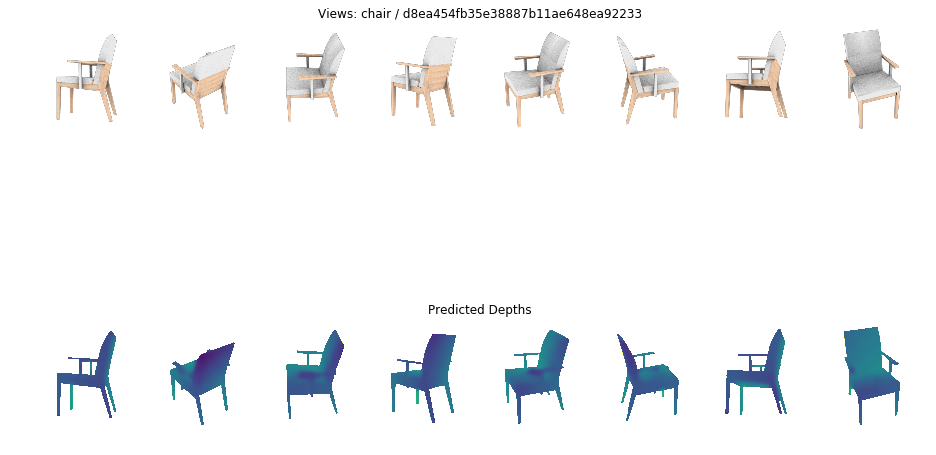

In [9]:
from vis_utils import image_grid

# Visualize views
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(16, 10))
plt.subplot(2, 1, 1)
plt.imshow(image_grid(ims))
plt.title('Views: {:s} / {:s}'.format(dset.splits[rand_sid]['name'], rand_mid))
plt.axis('off')
plt.subplot(2, 1, 2)
mask = np.logical_and(pred_depth > 2 - 0.5 * np.sqrt(3),  pred_depth < 2 + 0.5 * np.sqrt(3))
plt.imshow(image_grid(pred_depth, mask=mask)[..., 0])
plt.title('Predicted Depths')
plt.axis('off')
plt.show()

In [11]:
from IPython.display import display
from IPython.core.display import HTML
from vis_utils import unproject_depth, plot_points

# Visualize unprojected point cloud. Feel free to play around with the model!
pts, clr = [], []
dmin, dmax = 2.0 - 0.5*np.sqrt(3), 2.0 + 0.5*np.sqrt(3)
for ix in range(pred_depth.shape[1]):
    dpts, dclr = unproject_depth(pred_depth[0, ix, ..., 0], K[0, ix], R[0, ix], im=ims[0, ix], dmin=dmin, dmax=dmax)
    pts.append(dpts)
    clr.append(dclr)
pts = np.concatenate(pts, axis=0)
clr = np.concatenate(clr, axis=0)
display(plot_points(pts, clr, size=0.005, title='Predicted Point Cloud'))

# Center outputs
HTML("""
<style>
.output {
    align-items: center;
}
</style>
""")